In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import mediapipe as mp
from collections import deque
import os
import pickle
from tqdm import tqdm

In [310]:
landmark_path = os.path.join(os.getcwd(), 'archive', 'landmarks')
landmarked_imgs_path = os.path.join(os.getcwd(), 'archive', 'landmarked_imgs')
images_path = os.path.join(os.getcwd(), 'archive', 'LIS-fingerspelling-dataset')

checkpoints_folder_path = os.path.join(os.getcwd(), 'checkpoint', 'landmark')


## UTILS

In [ ]:
def random_shuffle(array1, array2, array3):
    assert len(array1) == len(array2) == len(array3), "All arrays must have the same length"
    shuffled_indices = list(range(len(array1)))
    random.shuffle(shuffled_indices)
    shuffled_array1 = [array1[i] for i in shuffled_indices]
    shuffled_array2 = [array2[i] for i in shuffled_indices]
    shuffled_array3 = [array3[i] for i in shuffled_indices]
    return shuffled_array1, shuffled_array2, shuffled_array3


# Preprocessing function to extract landmarks
def extract_hand_landmarks(results):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            return landmarks
    return None

def center_landmarks(landmarks):
    """
    Center and scale hand landmarks around the wrist (landmark 0).

    Parameters:
        landmarks (list or np.ndarray): Flat list or array of 63 values (21 landmarks * 3 coordinates)

    Returns:
        np.ndarray: Preprocessed landmarks, same shape (63,)
    """
    # Convert to numpy array
    landmarks = np.array(landmarks)

    # Reshape to (21, 3)
    landmarks = landmarks.reshape((21, 3))

    # Step 1: Centering - subtract wrist coordinates
    wrist = landmarks[0]
    centered = landmarks - wrist

    # Step 2: Scaling - normalize by maximum distance from wrist
    # Compute Euclidean distances from wrist to each point
    distances = np.linalg.norm(centered, axis=1)
    max_distance = distances.max()

    # To avoid division by zero (if max_distance is 0)
    if max_distance > 0:
        scaled = centered / max_distance
    else:
        scaled = centered  # if hand is not detected well, just keep centered

    # Flatten back to (63,)
    return scaled.flatten()

def predict_test(label_encoder, model, paths):
    model.eval()
    # Define MediaPipe hands
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7, max_num_hands=1) as hands:
        images = []
        features = []
        labels = []
        for path in paths:
            new_path = os.path.join(os.getcwd(), 'archive', 'LIS-fingerspelling-dataset',path.split('/')[-2], path.split('/')[-1][:-4])+'.JPG'
            img = cv2.imread(new_path,cv2.IMREAD_COLOR)
            results = hands.process(img)
            landmarks = extract_hand_landmarks(results)
            label = path.split('/')[-2]
            if landmarks:
                landmarks = center_landmarks(landmarks)
                images.append(img)
                features.append(landmarks)
                labels.append(label)
                
                        
        features = np.stack(features) 
        features = torch.tensor(features, dtype=torch.float32)    
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)

    predicted_labels = label_encoder.inverse_transform(predicted)
    return images, predicted_labels, labels


def showcase(label_encoder, model, paths, mode = 'random'):
    images, predicted_labels, labels = predict_test(label_encoder, model, paths)
    indices = []
    if mode == 'random':
        images, predicted_labels, labels = random_shuffle(images, predicted_labels, labels)
        indices = range(8)
    elif mode == 'wrong':
        for i in range(len(predicted_labels)):
            if predicted_labels[i] != labels[i]:
                indices.append(i)
                random.shuffle(indices)
        print(f"Wrongly predicted {len(indices)}/{len(labels)} images")
    elif mode == 'correct':
        for i in range(len(predicted_labels)):
            if predicted_labels[i] == labels[i]:
                indices.append(i)
                random.shuffle(indices)
        print(f"Correctly predicted {len(indices)}/{len(labels)} images")
    else:
        raise ValueError("Mode must be 'random' or 'wrong' or 'correct'")
    plt.figure(figsize=(12, 4))
    for i in range(min(8, len(indices))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[indices[i]].squeeze(), cmap='gray')
        plt.title(f"Predicted: {predicted_labels[indices[i]].item()}, True: {labels[indices[i]]}")
        plt.axis('off')
    plt.show()



In [312]:
# === 1. Data ===
def gather_data(path):
    landmarks_list = []
    labels_list = []
    paths_list = []
    for j in os.listdir(path):
        if j != 'readme.txt': 
            for k in os.listdir(path+ '/'+str(j)):
                tmp_path = path +'/'+ str(j)+'/'+str(k)
                landmarks = np.load(tmp_path, allow_pickle=True)
                landmarks_list.append(landmarks)
                labels_list.append(j)
                paths_list.append(tmp_path)
    features = np.stack(landmarks_list, axis=0)
    labels = np.array(labels_list)
    return features, labels, paths_list


class SignLanguageDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [313]:
# === 2. MLP Model ===

class SignLanguageMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SignLanguageMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [314]:
# === 3. Training Function ===

def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for features, labels in dataloader:
        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

In [315]:
# === 4. Evaluation Function ===

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in dataloader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
# === 5. Main Training Loop ===

def main():
    # === Load your preprocessed numpy data ===
    # Example: features.npy and labels.npy

    features, labels_raw, paths = gather_data(landmark_path)


    # Encode string labels to integers
    if not os.path.exists(os.path.join(checkpoints_folder_path,'label_encoder.pkl')):
        le = LabelEncoder()
        labels = le.fit_transform(labels_raw)
    else:
        le = pickle.load(open(os.path.join(checkpoints_folder_path,'label_encoder.pkl'), 'rb'))
        labels = le.transform(labels_raw)

    num_classes = len(le.classes_)


    # Split data: 70% train, 15% validation, 15% test
    X_temp, X_test, y_temp, y_test, paths_temp, paths_test = train_test_split(features, labels,paths,  test_size=0.15, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(X_temp, y_temp, paths_temp, test_size=0.1765, random_state=42, stratify=y_temp)
    # 0.1765 * 0.85 ≈ 0.15 to balance the splits


    # Create datasets and loaders
    train_loader = DataLoader(SignLanguageDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(SignLanguageDataset(X_val, y_val), batch_size=32, shuffle=False)
    test_loader = DataLoader(SignLanguageDataset(X_test, y_test), batch_size=32, shuffle=False)


    # Initialize model, loss function, and optimizer
    model = SignLanguageMLP(input_size=features.shape[1], num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Test before training
    print('SHOWCASING BEFORE TRAINING')
    print('='*70)
    showcase(le, model, paths_test)

    # Training loop
    if not os.path.exists(os.path.join(checkpoints_folder_path,'best_model.pth')):
        num_epochs = 1500
        best_val_acc = 0
        progress_bar = tqdm(range(num_epochs))
        for epoch in progress_bar:
            train_loss, train_acc = train(model, train_loader, criterion, optimizer)
            val_acc = evaluate(model, val_loader)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), os.path.join(checkpoints_folder_path, 'best_model.pth'))

        with open(os.path.join(checkpoints_folder_path,'label_encoder.pkl'), 'wb') as f:
            pickle.dump(le, f)

            progress_bar.set_postfix(Epoch = f"[{epoch+1}/{num_epochs}]")
            progress_bar.set_postfix(Train = f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f}" )
            progress_bar.set_postfix(Val = f"Acc: {val_acc:.4f}")

    
    model.load_state_dict(torch.load(os.path.join(checkpoints_folder_path, 'best_model.pth'), map_location=torch.device('cpu')))
    model.eval()

    # Evaluate on test set
    test_acc = evaluate(model, test_loader)
    print(f'Test Accuracy: {test_acc:.4f}')

    print('SHOWCASING WRONGS AFTER TRAINING')
    print('='*70)
    showcase(le, model, paths_test, 'wrong')
    print('SHOWCASING CORRECTS AFTER TRAINING')
    print('='*70)
    showcase(le, model, paths_test, 'correct')

    


SHOWCASING BEFORE TRAINING


I0000 00:00:1744561507.806579   11661 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744561507.808927   19399 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 19.1.1, DRM 3.59, 6.11.0-19-generic)
W0000 00:00:1744561507.825725   19387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744561507.847006   19384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


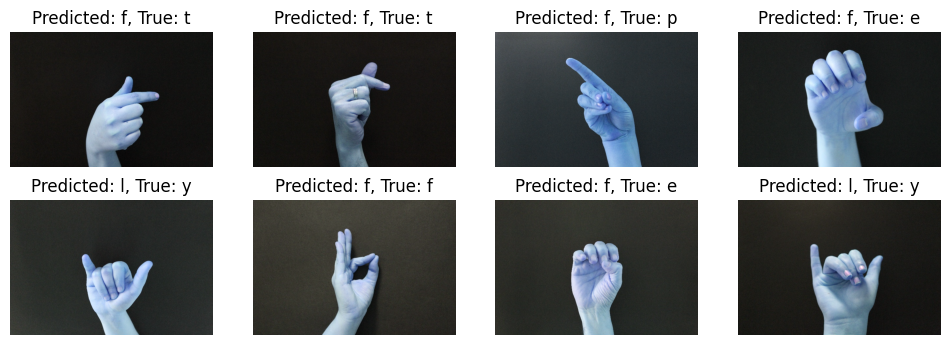

100%|██████████| 500/500 [01:00<00:00,  8.33it/s]
I0000 00:00:1744561582.869497   11661 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744561582.872563   19451 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 19.1.1, DRM 3.59, 6.11.0-19-generic)
W0000 00:00:1744561582.886415   19438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744561582.900055   19439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Test Accuracy: 0.9799
Test Accuracy: 0.9854
SHOWCASING WRONGS AFTER TRAINING
Wrongly predicted 15/356 images


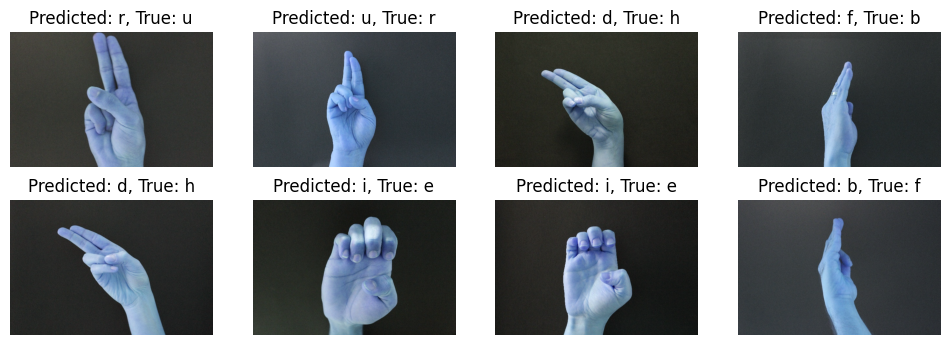

SHOWCASING CORRECTS AFTER TRAINING


I0000 00:00:1744561597.569924   11661 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744561597.572403   19472 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 19.1.1, DRM 3.59, 6.11.0-19-generic)
W0000 00:00:1744561597.585730   19461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744561597.598450   19458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Correctly predicted 341/356 images


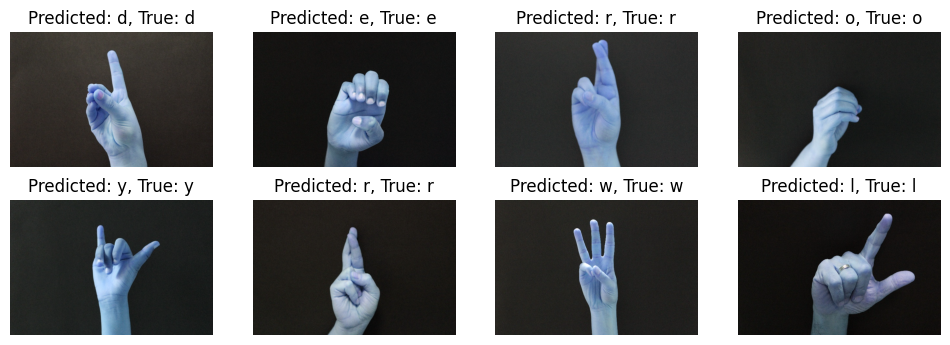

In [317]:
main()